# MBA em Ciência de Dados
### Universidade de São Paulo, São Carlos, Brasil

**Disciplina:** Aprendizado de Máquina

**Professor Reponsavel:** Prof. Dr. André Carlos Ponce de Leon Ferreira de Carvalho
📧 andre@icmc.usp.br
🌐 [linkedin](https://www.linkedin.com/in/andr%C3%A9-carlos-ponce-de-leon-f-de-carvalho-151bb26/)
🔗 [site](http://www.cemeai.icmc.usp.br/component/teamdisplay/108)

# Prática: Classificação de medicamentos usando árvore de decisão

**Autor:** Edesio Alcobaça
📧 edesio@usp.br
🌐 [linkedin](https://www.linkedin.com/in/ealcobaca/)
🔗 [site](https://ealcobaca.github.io/)

## Descrição & Objetivo

**Descrição dos Dados:** Uma empresa farmacêutica desenvolveu e testou dois diferentes medicamentos para o tratamento de uma doença. Os pesquisadores perceberam que o remédio A se comportava melhor para alguns pacientes enquanto que o B foi melhor para outro grupo de pacientes. Foram coletadas as seguintes características dos pacientes: idade (Age), sexo (Sex), pressão sanguínea (BP) e nível de colesterol (Cholesterol). Você foi acionado pela equipe para construir uma solução automática para recomendar o melhor medicamento. Contudo, como se trata de um medicamento, é esperado que esta recomendação seja transparente, i.e., o paciente precisa entender exatamente o motivo de tal recomendação. 

**Objetivo:** Construir regras claras e bem definidas para recomendar o  melhor medicamento dado as características do paciente.

# 1. Leitura dos Dados


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score


In [2]:
# Leitura de dados
data = pd.read_csv("drug_data.csv")
data

,Age,Sex,BP,Cholesterol,Drug
0,23,F,HIGH,HIGH,B
1,28,F,NORMAL,HIGH,A
2,61,F,LOW,HIGH,B
3,22,F,NORMAL,HIGH,A
4,49,F,NORMAL,HIGH,B
...,...,...,...,...,...
140,72,M,LOW,HIGH,B
141,46,F,HIGH,HIGH,B
142,52,M,NORMAL,HIGH,A
143,23,M,NORMAL,NORMAL,A


# 2. Análise Exploratória dos Dados


In [3]:
# Contar classes
data["Drug"].value_counts()

B    91
A    54
Name: Drug, dtype: int64

In [4]:
# Porcentagem de exemplos de cada classe
data["Drug"].value_counts(True)

B    0.627586
A    0.372414
Name: Drug, dtype: float64

In [5]:
# Verificar se tem NaN
data.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Drug           0
dtype: int64

In [6]:
# Descrever dados categóricos
data.describe(include=[object])


,Sex,BP,Cholesterol,Drug
count,145,145,145,145
unique,2,3,2,2
top,F,NORMAL,NORMAL,B
freq,74,59,78,91


In [7]:
# Descrever dados numéricos
data.describe(include=[np.number])


,Age
count,145.000000
mean,43.848276
std,16.755319
min,15.000000
25%,30.000000
50%,43.000000
75%,58.000000
max,74.000000


# 3. Modelagem & Avaliação

## 3.1 Baseline

In [8]:
# Separar os dados em treinamento e teste

categorical_features = ["Sex", "BP", "Cholesterol"]
numerical_features = ["Age"]

X = data.drop(columns=["Drug"])
y = data["Drug"].astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [9]:
lrc = LogisticRegression(random_state=42)

cv_list_lr_baseline = cross_val_score(
    lrc,
    X_train[numerical_features],
    y_train,
    cv=10,
    scoring="balanced_accuracy"
)

In [10]:
mean_cv_lr_baseline = np.mean(cv_list_lr_baseline)
std_cv_lr_baseline = np.std(cv_list_lr_baseline)

print(f"Performance (bac): {round(mean_cv_lr_baseline, 4)} +- {round(std_cv_lr_baseline, 4)}")

Performance (bac): 0.5 +- 0.0


# 3.2 Tratando Dados Categóricos

Embora os algoritmos de árvore de decisão tenham sido inicialmente criados para lidar com dados categóricos, os algoritmos do sklearn só trabalham com dados numéricos. Portanto, precisamos transformar os atributos categóricos para numéricos usando, por exemplo, o  [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) ou [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [11]:
# Esse comando vai transformar as categorias em números
oe = OrdinalEncoder()
oe.fit(data[["Sex", "BP"]])
oe.transform(data[["Sex", "BP"]])[:10]


array([[0., 0.],
       [0., 2.],
       [0., 1.],
       [0., 2.],
       [0., 2.],
       [1., 2.],
       [1., 1.],
       [0., 0.],
       [1., 1.],
       [0., 1.]])

In [12]:
# Podemos transformar as features de forma diferente
# Para isso podemos usar o ColumnTransformer

tr = ColumnTransformer(
    transformers=[
        ("cat-enc", OrdinalEncoder(), categorical_features),
        # ("min-max", MinMaxScaler(), numerical_features)
    ]
)

tr.fit_transform(X_train)[:10]

array([[0., 2., 1.],
       [1., 1., 1.],
       [0., 1., 1.],
       [0., 0., 1.],
       [1., 1., 1.],
       [1., 2., 1.],
       [0., 1., 1.],
       [0., 0., 0.],
       [0., 2., 0.],
       [0., 0., 0.]])

In [13]:
# Podemos transformar as features de forma diferente
# Para isso podemos usar o ColumnTransformer

tr = ColumnTransformer(
    transformers=[
        ("cat-enc", OrdinalEncoder(), categorical_features),
        ("min-max", MinMaxScaler(), numerical_features)
    ]
)

tr.fit_transform(X_train)[:10]

array([[0.        , 2.        , 1.        , 0.08474576],
       [1.        , 1.        , 1.        , 0.50847458],
       [0.        , 1.        , 1.        , 0.61016949],
       [0.        , 0.        , 1.        , 0.06779661],
       [1.        , 1.        , 1.        , 0.57627119],
       [1.        , 2.        , 1.        , 0.13559322],
       [0.        , 1.        , 1.        , 0.08474576],
       [0.        , 0.        , 0.        , 0.72881356],
       [0.        , 2.        , 0.        , 0.42372881],
       [0.        , 0.        , 0.        , 0.45762712]])

In [14]:
# Podemos transformar as features de forma diferente
# Para isso podemos usar o ColumnTransformer

tr = ColumnTransformer(
    transformers=[
        ("cat-enc", OrdinalEncoder(), categorical_features),
        # ("min-max", MinMaxScaler(), numerical_features)
    ],
    remainder='passthrough' # passa para frente demais features
)

tr.fit_transform(X_train)[:10]

array([[ 0.,  2.,  1., 20.],
       [ 1.,  1.,  1., 45.],
       [ 0.,  1.,  1., 51.],
       [ 0.,  0.,  1., 19.],
       [ 1.,  1.,  1., 49.],
       [ 1.,  2.,  1., 23.],
       [ 0.,  1.,  1., 20.],
       [ 0.,  0.,  0., 58.],
       [ 0.,  2.,  0., 40.],
       [ 0.,  0.,  0., 42.]])

# 3.2 Modelando uma árvore de decisão

Para isso, podemos usar a classe <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">DecisionTreeClassifier</a>, que gera modelos do algoritmo DT.

Observe que é necessário configurar os parâmetros que controlam o tamanho da árvore para evitar overfitting.
Além disso, perdemos o entendimento do modelo ao criar árvores muito compridas. Veja a nota na documentação do algoritmo:

<b>Notes</b>

<i>The default values for the parameters controlling the size of the trees (e.g. <mark>max_depth</mark>, <mark>min_samples_leaf</mark>, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.</i>

### Sem limitar tamanho da árvore

In [15]:
categorical_features = ["Sex", "BP", "Cholesterol"]

ct = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
    ],
    remainder='passthrough' # passa para frente demais features
)

dt = DecisionTreeClassifier(
    criterion="gini",        # critério para medir a qualidade da divisão (split)
    class_weight="balanced", # atribuir o mesmo peso para as duas classes
    random_state=42
 )

pipe1 = Pipeline([
    ('preprocessing-1', ct),
    ('model', dt)
])

In [16]:
cv_list_dt = cross_val_score(
    pipe1,
    X_train,
    y_train,
    cv=10,
    scoring="balanced_accuracy"
)

In [17]:
mean_cv_dt = np.mean(cv_list_dt)
std_cv_dt = np.std(cv_list_dt)

print(f"Performance (bac): {round(mean_cv_dt, 4)} +- {round(std_cv_dt, 4)}")

Performance (bac): 0.6643 +- 0.1602


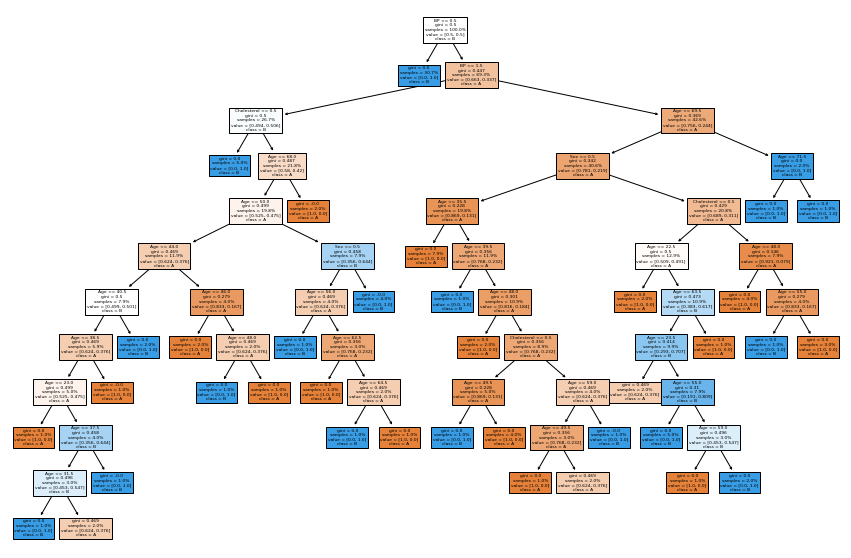

In [18]:
pipe1.fit(X_train, y_train)

model = pipe1["model"]
X_train_prep = pipe1["preprocessing-1"].transform(X_train)
feature_names = pipe1["preprocessing-1"].transformers_[0][2] + X_train.columns[pipe1["preprocessing-1"].transformers_[1][2]].to_list()
class_names = ["A", "B"]

plt.figure(figsize=(15,10))
plot_tree(
    model.fit(X_train_prep, y_train),
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    proportion=True
)
plt.show(True)

### Limitando o tamanho da árvore

In [19]:
categorical_features = ["Sex", "BP", "Cholesterol"]

ct = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
    ],
    remainder='passthrough' # passa para frente demais features
)

dt = DecisionTreeClassifier(
    criterion="gini",        # critério para medir a qualidade da divisão (split)
    max_depth=3,             # profundidade máxima da árvore
    min_samples_leaf=0.01,   # número mínimo de folhas em um nó
    class_weight="balanced", # atribuir o mesmo peso para as duas classes
    random_state=42
 )

pipe2 = Pipeline([
    ('preprocessing-1', ct),
    ('model', dt)
])

In [20]:
cv_list_dt2 = cross_val_score(
    pipe2,
    X_train,
    y_train,
    cv=10,
    scoring="balanced_accuracy"
)

In [21]:
mean_cv_dt2 = np.mean(cv_list_dt2)
std_cv_dt2 = np.std(cv_list_dt2)

print(f"Performance (bac): {round(mean_cv_dt2, 4)} +- {round(std_cv_dt2, 4)}")

Performance (bac): 0.7845 +- 0.1012


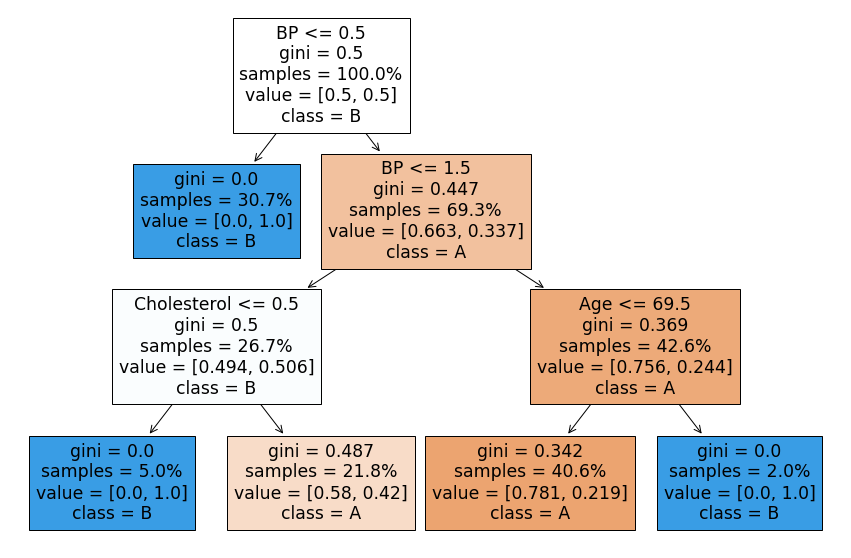

In [22]:
pipe2.fit(X_train, y_train)

model = pipe2["model"]
X_train_prep = pipe2["preprocessing-1"].transform(X_train)
feature_names = pipe2["preprocessing-1"].transformers_[0][2] + X_train.columns[pipe2["preprocessing-1"].transformers_[1][2]].to_list()
class_names = ["A", "B"]

plt.figure(figsize=(15,10))
plot_tree(
    model.fit(X_train_prep, y_train),
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    proportion=True
)
plt.show(True)

In [23]:
# retreinar o pipeline selecionado com todos os dados de treinamento

pipe2.fit(X_train, y_train)
y_pred = pipe2.predict(X_test)
lr_pca_test = balanced_accuracy_score(y_test, y_pred) 

print("Performance: ", round(lr_pca_test, 4))


Performance:  0.8036


## 4. DTreeViz (Decision Tree Visualization)

In [26]:
# descomente o comando abaixo para instalar a dtreeviz
#!pip install dtreeviz

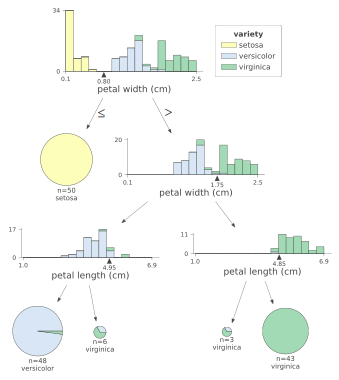

In [30]:
from sklearn.datasets import load_iris
from dtreeviz.trees import dtreeviz

import warnings
warnings.filterwarnings('ignore',  category=np.VisibleDeprecationWarning)

classifier = DecisionTreeClassifier(max_depth=3)
iris = load_iris()
classifier.fit(iris.data, iris.target)

viz = dtreeviz(classifier, 
               iris.data, 
               iris.target,
               target_name='variety',
               feature_names=iris.feature_names, 
               class_names=["setosa", "versicolor", "virginica"]
              )  
              
viz

target esperada:  virginica


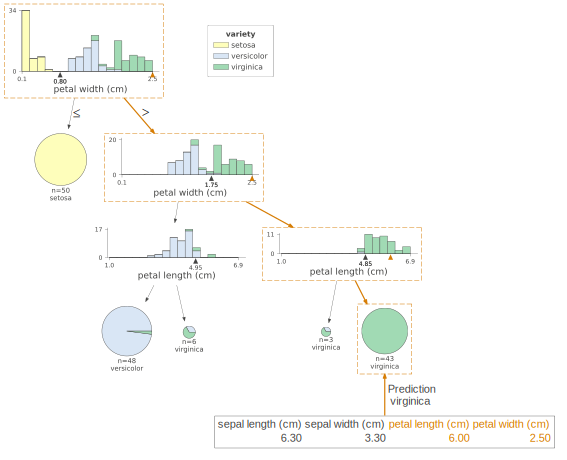

In [31]:
class_name = ["setosa", "versicolor", "virginica"]
print("target esperada: ", class_name[iris.target[100]])
viz = dtreeviz(classifier, 
               iris.data, 
               iris.target,
               target_name='variety',
               feature_names=iris.feature_names, 
               class_names=class_name,
               X=iris.data[100]
              )  
              
viz

## Referências & Links

1. [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#tree)
2. [Column Transformer](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)
3. [IBM drug data](https://www.kaggle.com/datasets/7f7bebbb020855aa344d19f2ce710e0128ec750263fc868840aa835eaf4cec05?resource=download)
4. [Classification And Regression Trees](https://www.taylorfrancis.com/books/mono/10.1201/9781315139470/classification-regression-trees-leo-breiman-jerome-friedman-richard-olshen-charles-stone)



<font size="1"> © <a href="https://github.com/ealcobaca">ealcobaca</a> *(2022)* </font>